# Preparación del entorno de trabajo

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
FILE_PATH = "/gdrive/My Drive/Colab Notebooks/Master/Vision por Computador/Practica 1/" #Guillermo
#FILE_PATH = "/gdrive/MyDrive/Colab Notebooks/COM VIS/Practica 1/" #Antonio

# Imports

In [3]:
import glob

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import pickle


from tensorflow.keras.layers import Input, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, SeparableConv2D, MaxPooling2D, add, UpSampling2D, Cropping2D
from tensorflow.keras import Model, losses
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model
from keras.layers.merge import concatenate
from keras.initializers import GlorotNormal

from scipy.spatial.distance import euclidean

from sklearn.cluster import KMeans

## Descargar desde Google Drive

In [4]:
with open(FILE_PATH + 'binary_60x80.pkl', 'rb') as file:
    X = pickle.load(file)

# Carga de los datos

In [5]:
with open(FILE_PATH + 'binary_60x80.pkl', 'rb') as file:
    X = pickle.load(file)

In [6]:
X.shape

(44400, 80, 60, 3)

# Definición de la arquitectura
Código basado en [Image segmentation with a U-Net-like architecture](https://keras.io/examples/vision/oxford_pets_image_segmentation/)

In [7]:
def get_model():
    inputs = Input(shape=(80, 60, 3))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = Activation("relu")(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Generate a vector with the representation of the image
    x = Flatten()(x)

    x = Dense(3)(x)
    x = Activation("sigmoid")(x)

    encoder = Model(inputs, x)

    x = Dense(5*4*256)(x)
    x = Activation("relu")(x)

    x = Reshape((5, 4, 256))(x)

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = Activation("relu")(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = UpSampling2D(2)(x)

        if filters != 256:
            # Project residual
            residual = UpSampling2D(2)(previous_block_activation)
            residual = Conv2D(filters, 1, padding="same")(residual)
            x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = Conv2D(3, 3, activation="sigmoid", padding="same")(x)
    outputs = Cropping2D(cropping=((0, 0), (2, 2)), data_format=None)(outputs)

    # Define the model
    autoencoder = Model(inputs, outputs)
    return encoder, autoencoder

In [8]:
encoder, autoencoder =  get_model()

## Ploteo de la arquitectura

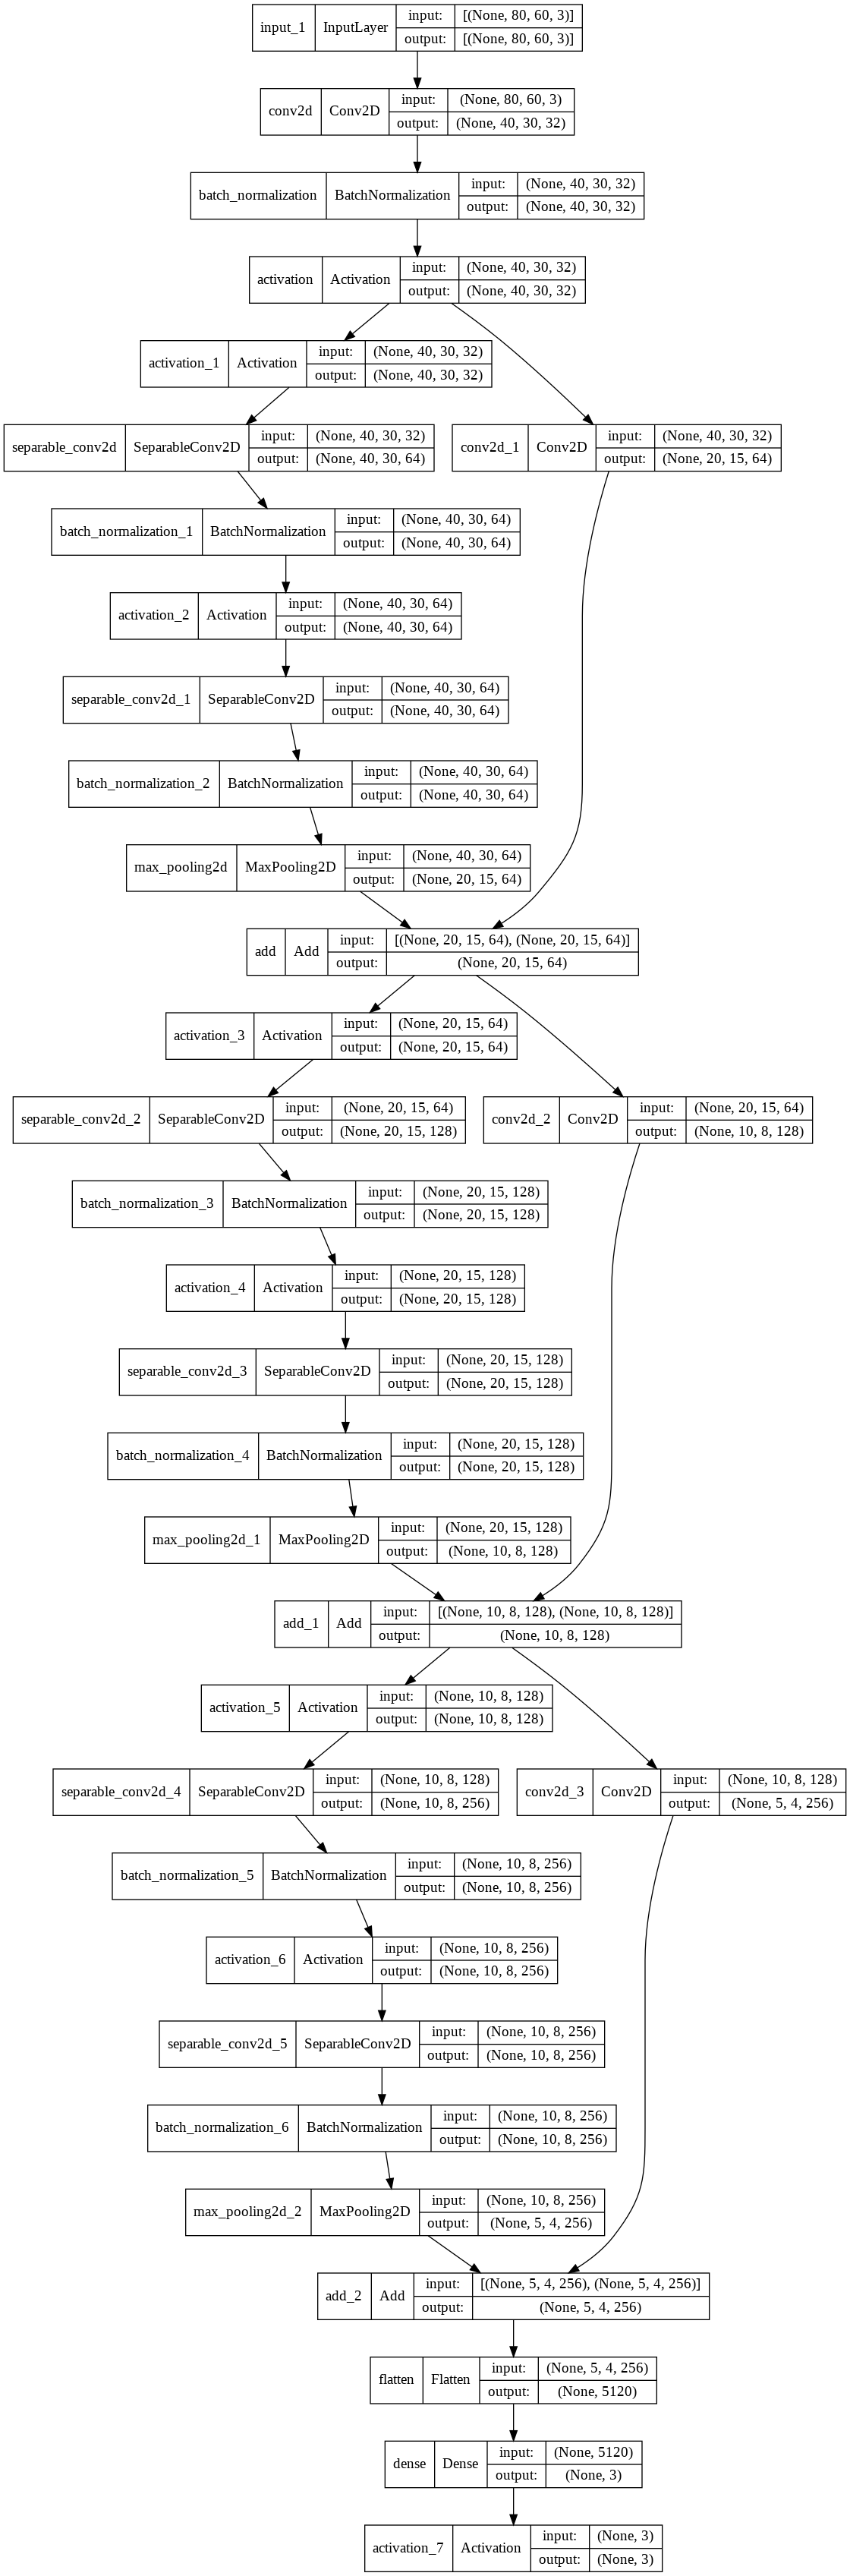

In [9]:
plot_model(encoder, show_layer_names=True, show_shapes=True)

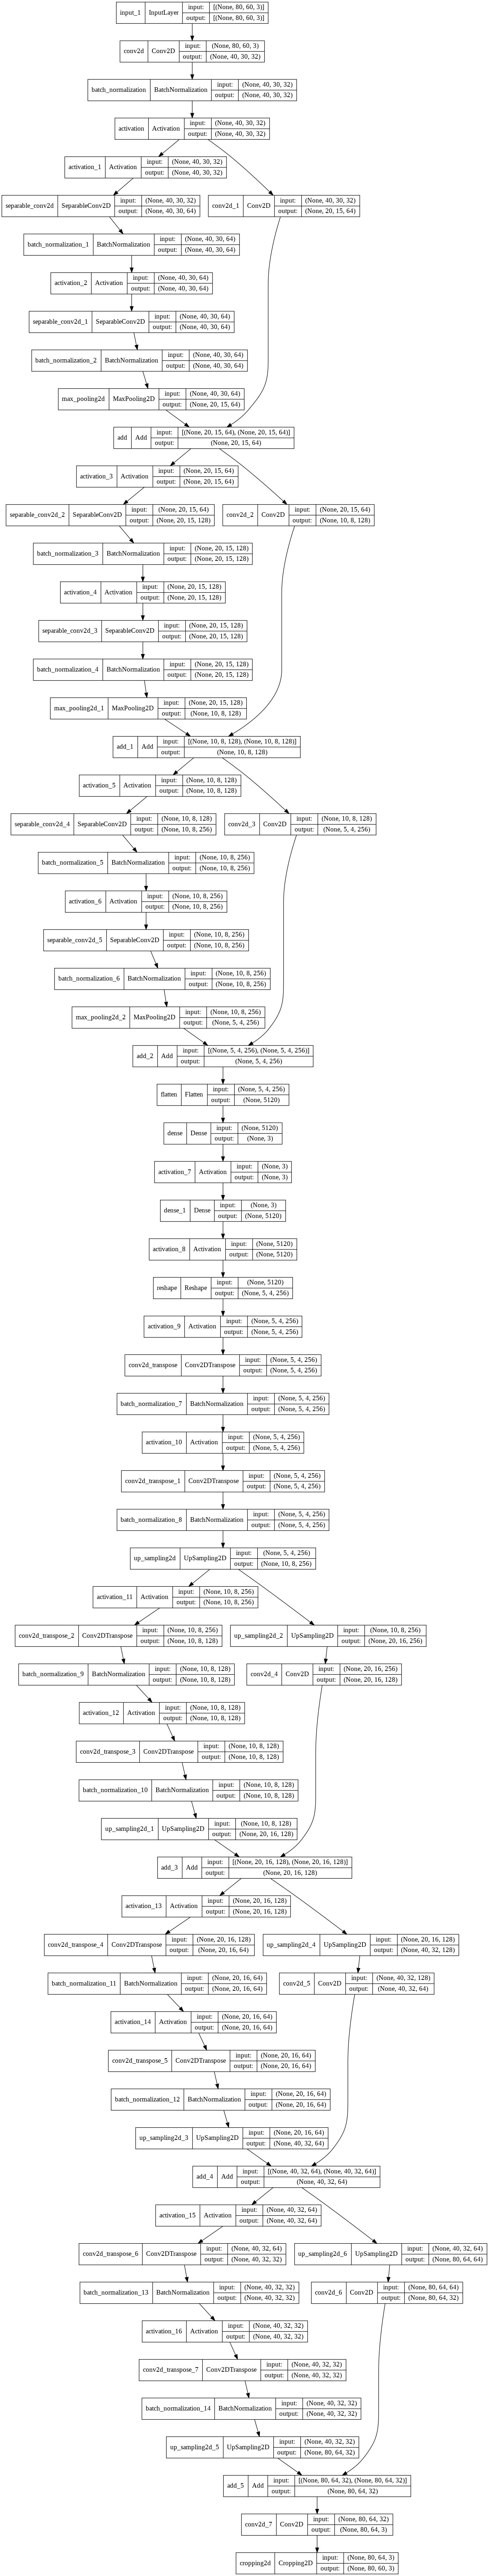

In [10]:
plot_model(autoencoder, show_layer_names=True, show_shapes=True)

## Definición de funciones de muestreo de resultados

In [11]:
def plot_reconstruction(n_plots, reconstructed_img_predictions, epoch, plot=False):
    f, axarr = plt.subplots(n_plots, 2, figsize=(6, 12))
    f.suptitle('Epoch: ' + str(epoch), fontsize=16)

    axarr[0,0].set_title('Source image')
    axarr[0,1].set_title('Reconstructed image')


    for i in range(n_plots):
        axarr[i,0].imshow(X[i])
        axarr[i,1].imshow(reconstructed_img_predictions[i])

        axarr[i,0].get_xaxis().set_visible(False)
        axarr[i,0].get_yaxis().set_visible(False)
        axarr[i,1].get_xaxis().set_visible(False)
        axarr[i,1].get_yaxis().set_visible(False)

    if plot:
        plt.plot()
    plt.savefig(FILE_PATH + "Results/" + epoch + 'reconstruction_results.png')

In [12]:
def plot_train_val(history):
    plt.rcParams['figure.figsize'] = [15, 5]
    f, ax1 = plt.subplots(1, 1, sharex=True)

    ax1.plot(history.history['mae'], label='mae (train)')
    ax1.plot(history.history['val_mae'], label='mae (test)')
    ax1.set_title('MAE')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()
    plt.plot()
    plt.savefig(FILE_PATH + "Results/losses.png")

## Entrenamiento del modelo

Definimos un callback personalizado que guarde los resultados a medida que sucede el entrenamiento

In [13]:
class SaveResults(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        plot_reconstruction(5, self.model.predict(X[:100]), epoch=str(epoch))

In [14]:
with tf.device('/device:GPU:0'):
    tf.keras.backend.clear_session()
    autoencoder.compile(
        loss='mse', 
        optimizer=Adam(), metrics=['mae'])
    history = autoencoder.fit(X[:40000], X[:40000],
                        epochs=50, batch_size=64, verbose=1,
                        validation_data=(X[40000:44400], X[40000:44400]),
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=7, monitor="val_loss",),
                                   SaveResults()])

Output hidden; open in https://colab.research.google.com to view.

Guardamos los pesos de las redes

In [15]:
autoencoder.save(FILE_PATH + 'Results/autoencoder.h5')
encoder.save(FILE_PATH + 'Results/encoder.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



## Evaluación del entrenamiento

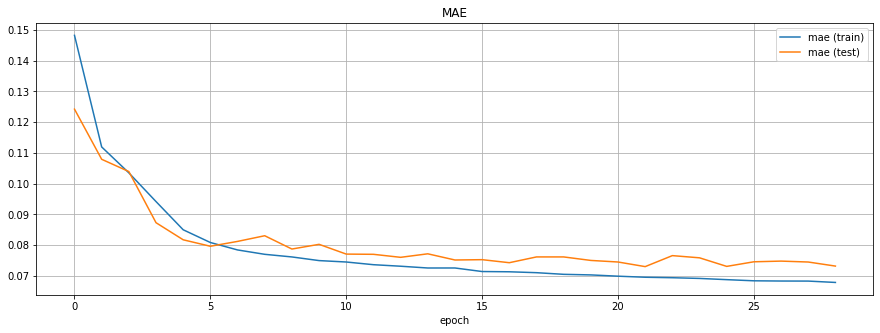

In [16]:
plot_train_val(history)

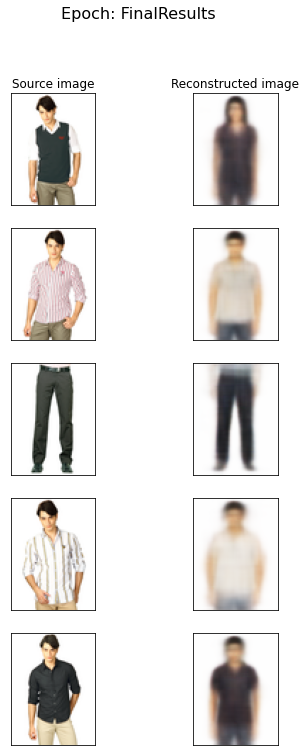

In [17]:
plot_reconstruction(5, autoencoder.predict(X[:100]), epoch='FinalResults')

# Predicción del sistema de recomendación

Se predicen las características que resumen a cada imagen haciendo uso del predict del encoder. De esta manera se sucede la reducción dimensional

In [18]:
encoder_predictions = encoder.predict(X[:1000])

In [19]:
encoder_predictions.shape

(1000, 3)

## Distribución de las imágenes

Muestreo de la distribución espacial de los resúmenes de cada imágen, cabe destacar que cada imagen la representan sus 2 dimensiones

In [20]:
fig = go.Figure(data=[go.Scatter3d(x=encoder_predictions[:,0], y=encoder_predictions[:,1], z=encoder_predictions[:,2],
                                   mode='markers')])
fig.show()

## Recomendación por clustering

In [21]:
kmeans = KMeans(n_clusters = 6, random_state=0)
kmeans.fit(encoder_predictions)

KMeans(n_clusters=6, random_state=0)

In [22]:
clusters = kmeans.predict(encoder_predictions)

In [23]:
fig = go.Figure(data=[go.Scatter3d(x=encoder_predictions[:,0], y=encoder_predictions[:,1], z=encoder_predictions[:,2],
                                   mode='markers',
                                   marker=dict(size=6,
                                               color=clusters,                # set color to an array/list of desired values
                                               colorscale='Viridis',   # choose a colorscale
                                               opacity=1))])
fig.show()

In [24]:
def clusters_full(cont_cluster, n_plots):
    for cluster in cont_cluster:
        if cluster < n_plots:
            return True

    return False

def plot_reconstruction_clusters(n_plots, n_clusters, imgs, clusters, plot=False):
    f, axarr = plt.subplots(n_clusters, n_plots, figsize=(3*n_plots, 3*n_clusters))
    cont = 0
    cont_cluster = [0 for i in range(n_clusters)]

    while clusters_full(cont_cluster, n_plots):
        if cont_cluster[clusters[cont]] < n_plots:
            axarr[clusters[cont], cont_cluster[clusters[cont]]].imshow(imgs[cont])
            axarr[clusters[cont], cont_cluster[clusters[cont]]].get_xaxis().set_visible(False)
            axarr[clusters[cont], cont_cluster[clusters[cont]]].get_yaxis().set_visible(False)
            
            cont_cluster[clusters[cont]] = cont_cluster[clusters[cont]]+1
        cont = cont+1

    if plot:
        plt.plot()
    plt.savefig(FILE_PATH + 'Results/recomendation_clusters_results.png')

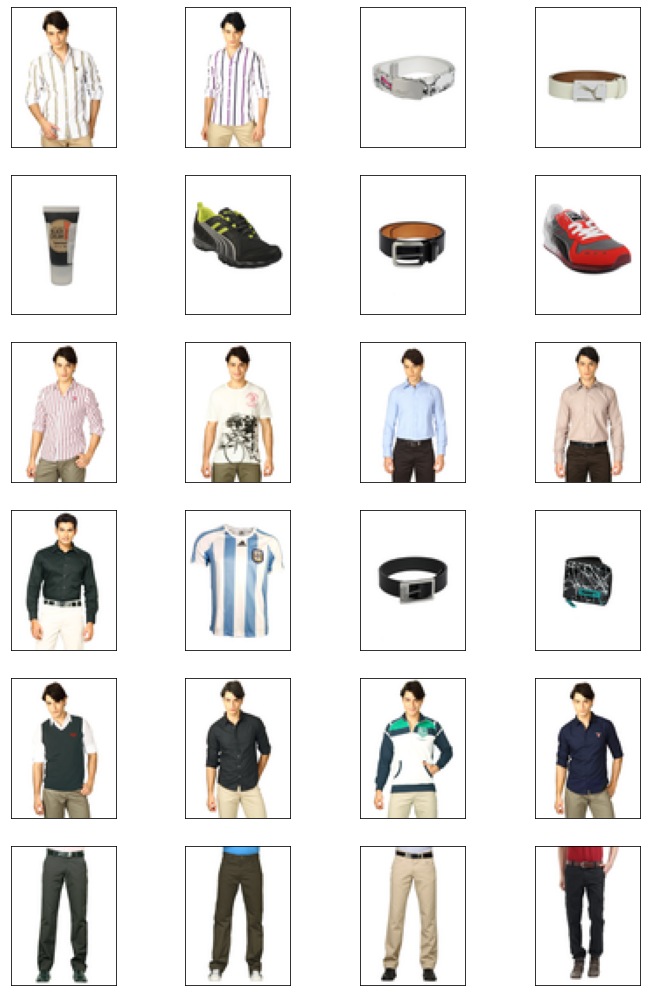

In [25]:
plot_reconstruction_clusters(4, max(clusters)+1, X, clusters, plot=True)

## Recomendación basada en vecino más cercano

In [26]:
def find_nearest_neighbor(img_index, encoder_predictions):
    img = encoder_predictions[img_index]
    img_nneighbor = None
    distance_min = 99999
    distance = 99999
    cont = 0

    for candidate in encoder_predictions:
        if cont != img_index:
            distance = euclidean(img, candidate)
            if distance < distance_min:
                distance_min = distance
                img_nneighbor = cont
        cont = cont+1

    return img_nneighbor, distance_min

In [27]:
def plot_nearest_neighbor(reconstructed_img_predictions, img_index, dataset):
    nneighbor, distance = find_nearest_neighbor(img_index, reconstructed_img_predictions)

    f, axarr = plt.subplots(1, 2, figsize=(6, 4))

    f.suptitle('Distance: ' + str(distance), fontsize=16)

    axarr[0].set_title('Source image')
    axarr[1].set_title('Nearest image')

    axarr[0].imshow(dataset[img_index])
    axarr[1].imshow(dataset[nneighbor])

    axarr[0].get_xaxis().set_visible(False)
    axarr[0].get_yaxis().set_visible(False)
    axarr[1].get_xaxis().set_visible(False)
    axarr[1].get_yaxis().set_visible(False)

    plt.savefig(FILE_PATH + 'Results/nearest_neighbor_results.png')

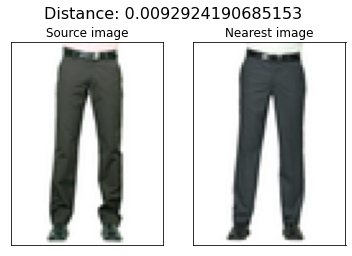

In [28]:
plot_nearest_neighbor(encoder_predictions, 2, X[:1000])